# pvlib-Python Forecasting (Denver, CO)
### Install Standard Release 

In [1]:
!pip install --upgrade pip

Requirement already up-to-date: pip in /home/nbuser/anaconda3_501/lib/python3.6/site-packages (20.1)


In [2]:
# Package from the Python Package Index
!pip install pvlib

# Module netCDF4 was not found 
!pip install netCDF4

# Module siphon was not found
!pip install siphon

# Downgrade to the prior release 
!pip install cftime==1.0.4.2
# Learned this from Birk
# Website: https://github.com/pvlib/pvlib-python/issues/895

# Try to save Excel
!pip install openpyxl

In [3]:
# Make basic imports and then set the location and time range data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pytz
import seaborn as sns; sns.set_color_codes()
import datetime

# Import pvlib forecast models
from pvlib.forecast import GFS, NAM, NDFD, HRRR, RAP
from pvlib import solarposition
from pvlib.location import Location
from matplotlib.pyplot import figure
from matplotlib import pyplot
%matplotlib inline

# Specify Location (Denver, CO)
latitude, longitude, tz = 39.7, -105.2, 'America/Denver'

# Specify time range
start = pd.Timestamp(datetime.date.today(), tz=tz)
end = start + pd.Timedelta(days=2)
irrad_vars = ['ghi','dni','dhi']

/home/nbuser/anaconda3_501/lib/python3.6/site-packages/pvlib/forecast.py:19: UserWarning: The forecast module algorithms and features are highly experimental. The API may change, the functionality may be consolidated into an io module, or the module may be separated into its own package.
  'The forecast module algorithms and features are highly experimental. '


In [4]:
pytz.all_timezones

['Africa/Abidjan',
 'Africa/Accra',
 'Africa/Addis_Ababa',
 'Africa/Algiers',
 'Africa/Asmara',
 'Africa/Asmera',
 'Africa/Bamako',
 'Africa/Bangui',
 'Africa/Banjul',
 'Africa/Bissau',
 'Africa/Blantyre',
 'Africa/Brazzaville',
 'Africa/Bujumbura',
 'Africa/Cairo',
 'Africa/Casablanca',
 'Africa/Ceuta',
 'Africa/Conakry',
 'Africa/Dakar',
 'Africa/Dar_es_Salaam',
 'Africa/Djibouti',
 'Africa/Douala',
 'Africa/El_Aaiun',
 'Africa/Freetown',
 'Africa/Gaborone',
 'Africa/Harare',
 'Africa/Johannesburg',
 'Africa/Juba',
 'Africa/Kampala',
 'Africa/Khartoum',
 'Africa/Kigali',
 'Africa/Kinshasa',
 'Africa/Lagos',
 'Africa/Libreville',
 'Africa/Lome',
 'Africa/Luanda',
 'Africa/Lubumbashi',
 'Africa/Lusaka',
 'Africa/Malabo',
 'Africa/Maputo',
 'Africa/Maseru',
 'Africa/Mbabane',
 'Africa/Mogadishu',
 'Africa/Monrovia',
 'Africa/Nairobi',
 'Africa/Ndjamena',
 'Africa/Niamey',
 'Africa/Nouakchott',
 'Africa/Ouagadougou',
 'Africa/Porto-Novo',
 'Africa/Sao_Tome',
 'Africa/Timbuktu',
 'Africa/

In [5]:
pytz.country_timezones('US')

['America/New_York',
 'America/Detroit',
 'America/Kentucky/Louisville',
 'America/Kentucky/Monticello',
 'America/Indiana/Indianapolis',
 'America/Indiana/Vincennes',
 'America/Indiana/Winamac',
 'America/Indiana/Marengo',
 'America/Indiana/Petersburg',
 'America/Indiana/Vevay',
 'America/Chicago',
 'America/Indiana/Tell_City',
 'America/Indiana/Knox',
 'America/Menominee',
 'America/North_Dakota/Center',
 'America/North_Dakota/New_Salem',
 'America/North_Dakota/Beulah',
 'America/Denver',
 'America/Boise',
 'America/Phoenix',
 'America/Los_Angeles',
 'America/Anchorage',
 'America/Juneau',
 'America/Sitka',
 'America/Metlakatla',
 'America/Yakutat',
 'America/Nome',
 'America/Adak',
 'Pacific/Honolulu']

### Instantiate a GFS model object and get the forecast data from Unidata

In [48]:
# GFS model, defaults to 0.5 degree resolution
# 0.25 deg available 
model = GFS() 

# Retrive data.returns panda.DataFrame object
raw_data = model.get_data(latitude, longitude, start, end)
print(raw_data.head())

                           Total_cloud_cover_convective_cloud  \
2020-04-22 06:00:00-06:00                                 0.0   
2020-04-22 09:00:00-06:00                                 0.0   
2020-04-22 12:00:00-06:00                                 0.0   
2020-04-22 15:00:00-06:00                                 0.0   
2020-04-22 18:00:00-06:00                                 0.0   

                           Total_cloud_cover_boundary_layer_cloud_Mixed_intervals_Average  \
2020-04-22 06:00:00-06:00                                                0.0                
2020-04-22 09:00:00-06:00                                                0.0                
2020-04-22 12:00:00-06:00                                                0.0                
2020-04-22 15:00:00-06:00                                                0.0                
2020-04-22 18:00:00-06:00                                                0.0                

                           Temperature_surface  \


### Process Data with pvlib

In [49]:
# Process this data before using it with pvlib
data = raw_data

# Rename the columns according the key/value pairs in model.variables.
data = model.rename(data)

# Convert temperature
data['temp_air'] = model.kelvin_to_celsius(data['temp_air'])

# Convert wind components to wind speed
data['wind_speed'] = model.uv_to_speed(data)

# Calculate irradiance estimates from cloud cover.
irrad_data = model.cloud_cover_to_irradiance(data['total_clouds'])
data = data.join(irrad_data, how='outer')

# Keep only the final data
data = data[model.output_variables]

print(data.head())

                            temp_air  wind_speed         ghi         dni  \
2020-04-22 06:00:00-06:00   4.583496    3.723207    0.000000    0.000000   
2020-04-22 09:00:00-06:00   3.066742    3.291675  411.124178  458.119851   
2020-04-22 12:00:00-06:00   1.950012    2.212731  537.504999  125.493670   
2020-04-22 15:00:00-06:00  13.239166    5.090334  316.190610   24.136529   
2020-04-22 18:00:00-06:00  22.081451    5.471852  121.297875   12.641593   

                                  dhi  total_clouds  low_clouds  mid_clouds  \
2020-04-22 06:00:00-06:00    0.000000          84.0         1.0        75.0   
2020-04-22 09:00:00-06:00  174.759461          17.0         0.0         0.0   
2020-04-22 12:00:00-06:00  428.984740          58.0         0.0         0.0   
2020-04-22 15:00:00-06:00  297.171115          91.0         0.0        87.0   
2020-04-22 18:00:00-06:00  117.112667          81.0         0.0        79.0   

                           high_clouds  
2020-04-22 06:00:00-06:00  

### GFS'S Class

In [50]:
# process_data method combines these steps in a single function
data = model.process_data(raw_data)
print(data.head())

# Implement their own process_data methods on inherited classes or implement similar stand-alone functions
# Also implement a get_processed_data() method that combines the get_data() and process_data() calls
data = model.get_processed_data(latitude, longitude, start, end)
print(data.head())

                            temp_air  wind_speed         ghi         dni  \
2020-04-22 06:00:00-06:00   4.583496    3.723207    0.000000    0.000000   
2020-04-22 09:00:00-06:00   3.066742    3.291675  411.124178  458.119851   
2020-04-22 12:00:00-06:00   1.950012    2.212731  537.504999  125.493670   
2020-04-22 15:00:00-06:00  13.239166    5.090334  316.190610   24.136529   
2020-04-22 18:00:00-06:00  22.081451    5.471852  121.297875   12.641593   

                                  dhi  total_clouds  low_clouds  mid_clouds  \
2020-04-22 06:00:00-06:00    0.000000          84.0         1.0        75.0   
2020-04-22 09:00:00-06:00  174.759461          17.0         0.0         0.0   
2020-04-22 12:00:00-06:00  428.984740          58.0         0.0         0.0   
2020-04-22 15:00:00-06:00  297.171115          91.0         0.0        87.0   
2020-04-22 18:00:00-06:00  117.112667          81.0         0.0        79.0   

                           high_clouds  
2020-04-22 06:00:00-06:00  

## Cloud Cover & Radiation

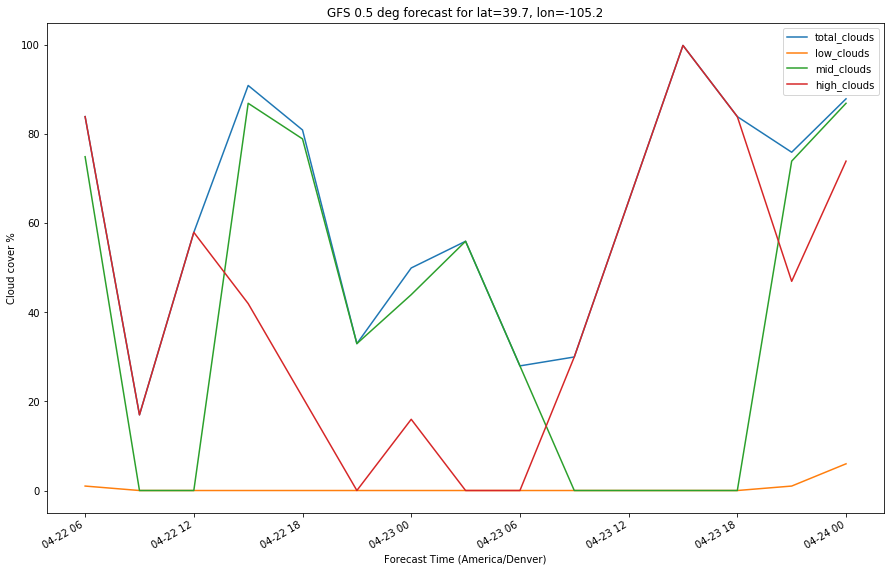

In [51]:
# Plot cloud cover percentages
cloud_vars = ['total_clouds', 'low_clouds','mid_clouds', 'high_clouds']
data[cloud_vars].plot(figsize=(15,10));
plt.ylabel('Cloud cover %');
plt.xlabel('Forecast Time ({})'.format(tz));
plt.title('GFS 0.5 deg forecast for lat={}, lon={}'.format(latitude, longitude));
plt.legend();

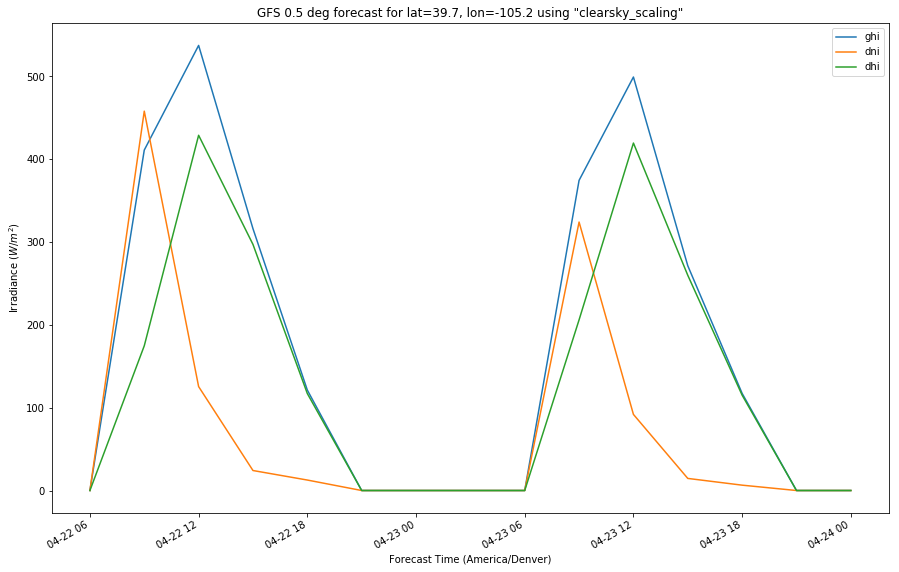

In [52]:
# Plot irradiance data
data = model.rename(raw_data)
irrads = model.cloud_cover_to_irradiance(data['total_clouds'], how='clearsky_scaling')
irrads.plot(figsize=(15,10));
plt.ylabel('Irradiance ($W/m^2$)');
plt.xlabel('Forecast Time ({})'.format(tz));
plt.title('GFS 0.5 deg forecast for lat={}, lon={} using "clearsky_scaling"'.format(latitude, longitude));
plt.legend();

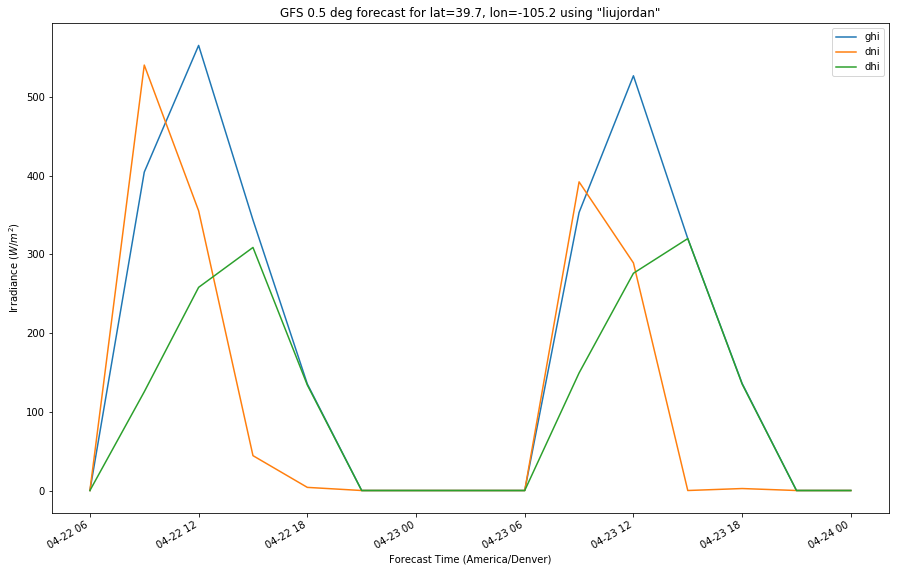

In [53]:
# Plot irradiance data
# Irradiance forecast one hour resolution as the weather data
irrads = model.cloud_cover_to_irradiance(data['total_clouds'], how='liujordan')
irrads.plot(figsize=(15,10));
plt.ylabel('Irradiance ($W/m^2$)');
plt.xlabel('Forecast Time ({})'.format(tz));
plt.title('GFS 0.5 deg forecast for lat={}, lon={} using "liujordan"'.format(latitude, longitude));
plt.legend();

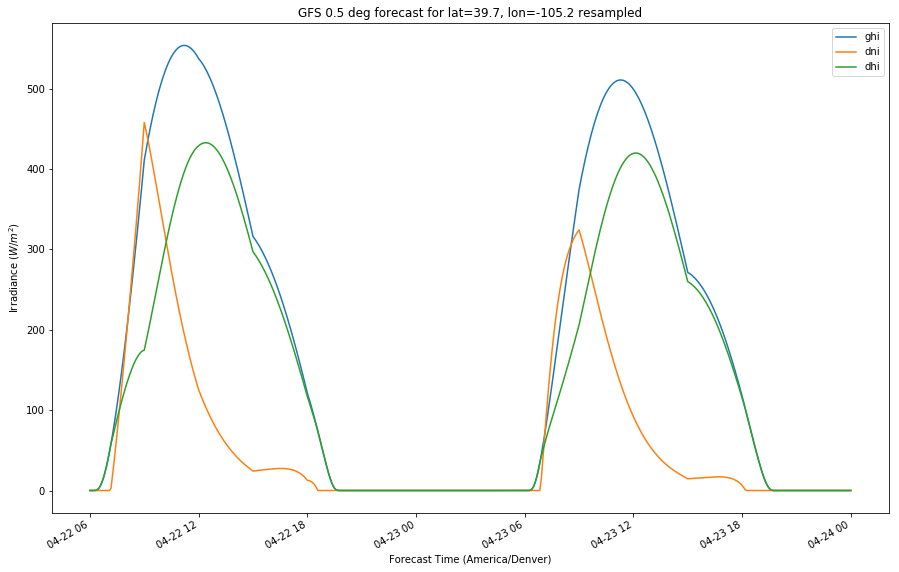

In [54]:
# Five min data resample
resampled_data = data.resample('5min').interpolate()
resampled_irrads = model.cloud_cover_to_irradiance(resampled_data['total_clouds'], how='clearsky_scaling')
resampled_irrads.plot(figsize=(15,10));
plt.ylabel('Irradiance ($W/m^2$)');
plt.xlabel('Forecast Time ({})'.format(tz));
plt.title('GFS 0.5 deg forecast for lat={}, lon={} resampled'.format(latitude,longitude));
plt.legend();

In [55]:
resampled_irrads

,ghi,dni,dhi
2020-04-22 06:00:00-06:00,0.000000,0.000000,0.000000
2020-04-22 06:05:00-06:00,0.000000,0.000000,0.000000
2020-04-22 06:10:00-06:00,0.000000,0.000000,0.000000
2020-04-22 06:15:00-06:00,0.011952,0.000000,0.011952
2020-04-22 06:20:00-06:00,0.240504,0.000000,0.240504
2020-04-22 06:25:00-06:00,1.077104,0.000000,1.077104
2020-04-22 06:30:00-06:00,2.929586,0.000000,2.929586
2020-04-22 06:35:00-06:00,6.022308,0.000000,6.022308
2020-04-22 06:40:00-06:00,10.396171,0.000000,10.396171
2020-04-22 06:45:00-06:00,15.988294,0.000000,15.988294


In [56]:
resampled_irrads.to_csv('5 min Irradiance.csv', encoding='utf-8')

## Weather Models
### GFS

In [57]:
# The Global Forecast System is the US model that provides forecast for the entire globe
# It is updated every six hours

### HRRR

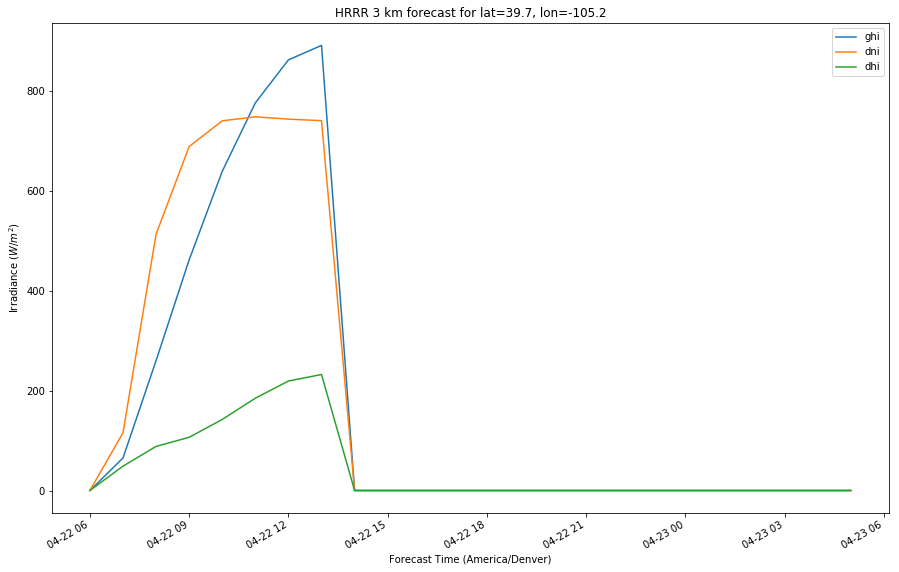

In [58]:
# High Resolution Rapid Refresh most accurate
# Only available for 15 hours
model = HRRR()
data = model.get_processed_data(latitude, longitude, start, end)
data[irrad_vars].plot(figsize=(15,10));
plt.ylabel('Irradiance ($W/m^2$)');
plt.xlabel('Forecast Time ({})'.format(tz));
plt.title('HRRR 3 km forecast for lat={}, lon={}'.format(latitude, longitude));
plt.legend();

### RAP

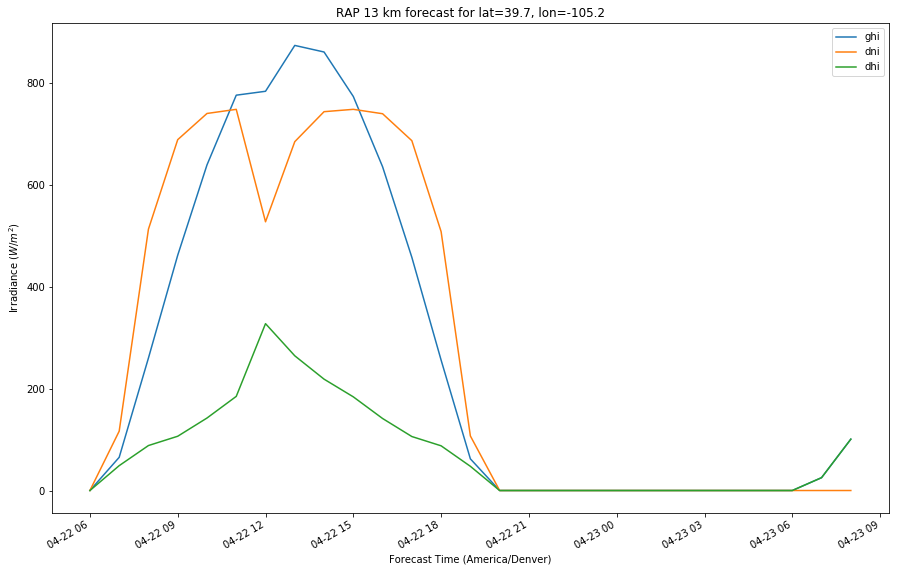

In [59]:
# The Rapid Refresh model is the parent model for the HRRR
# Updated every hour with a 20, 40 km resolution
model = RAP()
data = model.get_processed_data(latitude, longitude, start, end)
data[irrad_vars].plot(figsize=(15,10));
plt.ylabel('Irradiance ($W/m^2$)');
plt.xlabel('Forecast Time ({})'.format(tz));
plt.title('RAP 13 km forecast for lat={}, lon={}'.format(latitude, longitude));
plt.legend();

### NDFD

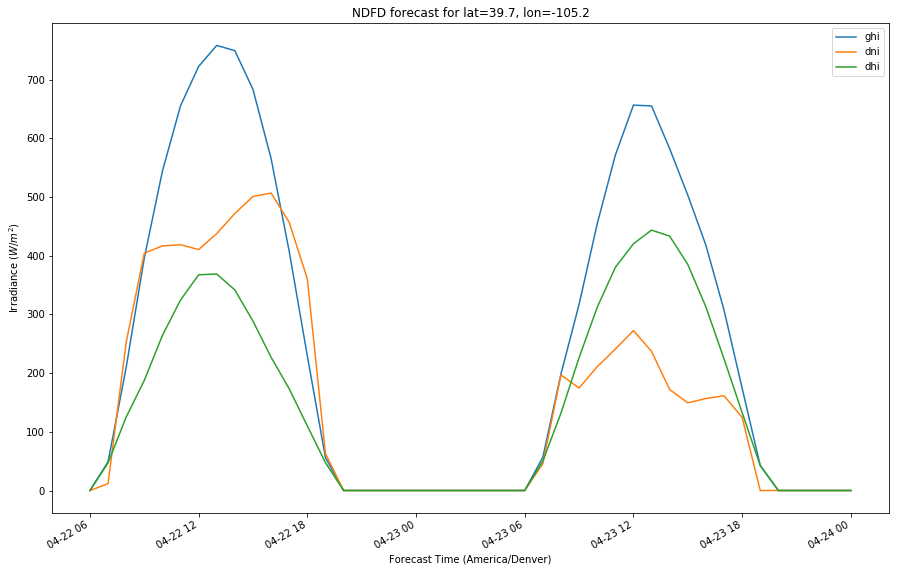

In [60]:
# The National Digital Forecast Database is not a model
# Is a collection of forecasts made by National Weather Service offices accross the country
# Updated every six hours
# Only available for the US
model = NDFD()
data = model.get_processed_data(latitude, longitude, start, end)
data[irrad_vars].plot(figsize=(15,10));
plt.ylabel('Irradiance ($W/m^2$)');
plt.xlabel('Forecast Time ({})'.format(tz));
plt.title('NDFD forecast for lat={}, lon={}'.format(latitude, longitude));
plt.legend();

## PV Power Forecast

In [61]:
from pvlib.pvsystem import PVSystem, retrieve_sam
from pvlib.temperature import TEMPERATURE_MODEL_PARAMETERS
from pvlib.tracking import SingleAxisTracker
from pvlib.modelchain import ModelChain

sandia_modules = retrieve_sam('sandiamod')
cec_inverters = retrieve_sam('cecinverter')
module = sandia_modules['Canadian_Solar_CS5P_220M___2009_']
inverter = cec_inverters['SMA_America__SC630CP_US__with_ABB_EcoDry_Ultra_transformer_']
temperature_model_parameters = TEMPERATURE_MODEL_PARAMETERS['sapm']['open_rack_glass_glass']

# model a big tracker for more fun
system = SingleAxisTracker(module_parameters=module, inverter_parameters=inverter, temperature_model_parameters=temperature_model_parameters, modules_per_string=15, strings_per_inverter=300)

# fx is a common abbreviation for forecast
fx_model = GFS()
fx_data = fx_model.get_processed_data(latitude, longitude, start, end)
ac_data = fx_data.resample('5min').interpolate()

# use a ModelChain object to calculate modeling intermediates
mc = ModelChain(system, fx_model.location)

# extract relevant data for model chain
mc.run_model(ac_data)

ModelChain: 
  name: None
  orientation_strategy: None
  clearsky_model: ineichen
  transposition_model: haydavies
  solar_position_method: nrel_numpy
  airmass_model: kastenyoung1989
  dc_model: sapm
  ac_model: snlinverter
  aoi_model: sapm_aoi_loss
  spectral_model: sapm_spectral_loss
  temperature_model: sapm_temp
  losses_model: no_extra_losses

### ModelChain Attributes

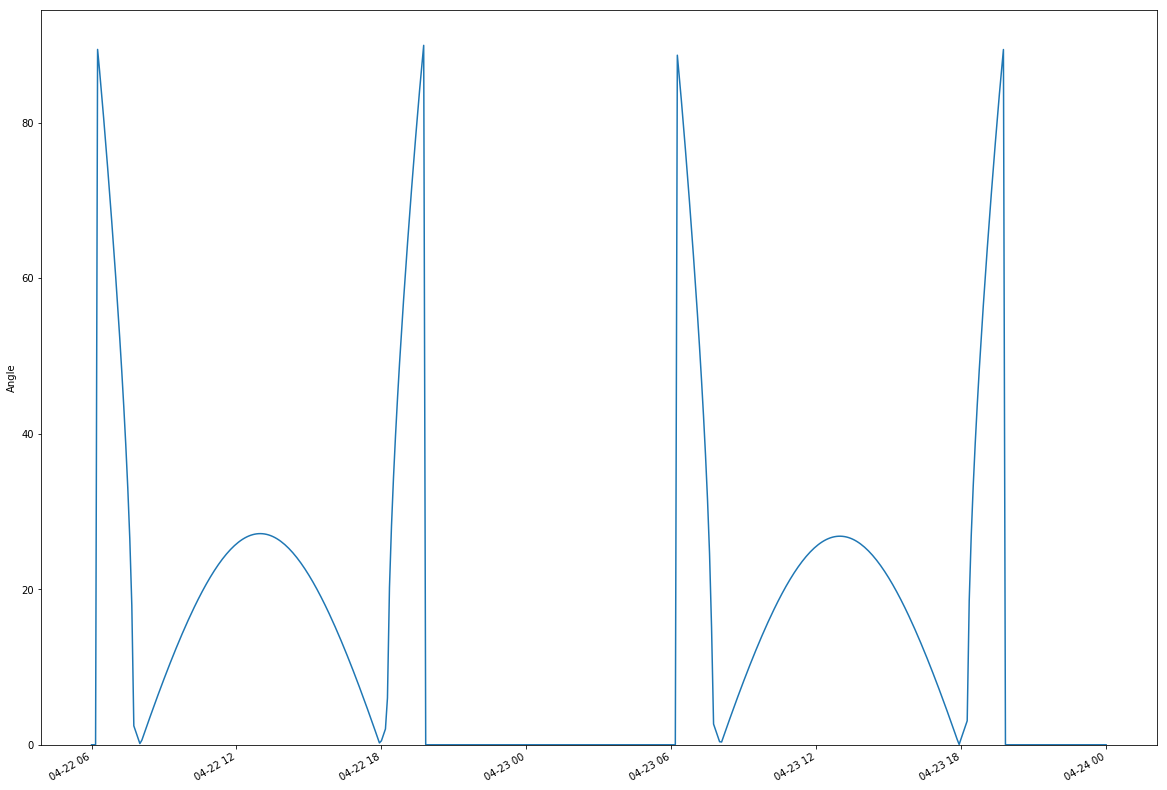

In [62]:
# ModelChain sotres modeling results on a series of attributes. 
# Angle of Incidence
mc.aoi.fillna(0).plot(figsize=(20,15));
plt.ylim(0, None);
plt.ylabel('Angle');

## Modeling intermediates & Forecast power

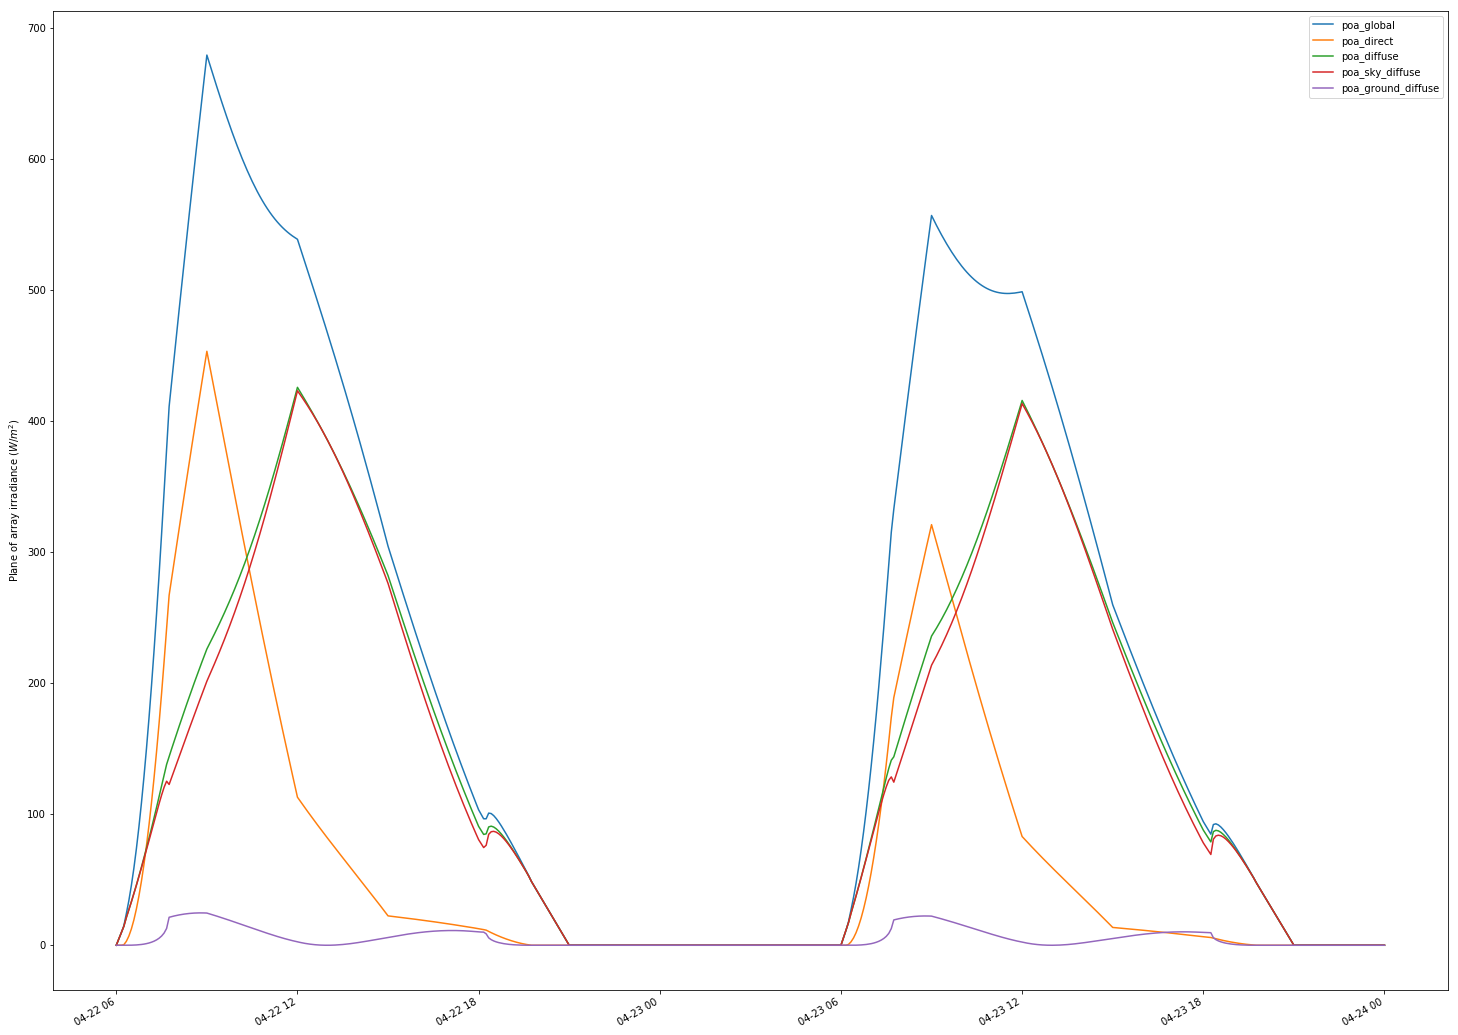

In [63]:
mc.total_irrad.plot(figsize=(25,20));
plt.ylabel('Plane of array irradiance ($W/m^2$)');
plt.legend(loc='best');

In [64]:
mc.total_irrad

,poa_global,poa_direct,poa_diffuse,poa_sky_diffuse,poa_ground_diffuse
2020-04-22 06:00:00-06:00,0.000000,-0.000000,0.000000,0.000000,0.000000
2020-04-22 06:05:00-06:00,4.808695,0.000000,4.808695,4.808695,0.000000
2020-04-22 06:10:00-06:00,9.525920,0.000000,9.525920,9.525920,0.000000
2020-04-22 06:15:00-06:00,14.792381,0.396070,14.396311,14.396183,0.000128
2020-04-22 06:20:00-06:00,24.155436,3.000817,21.154619,21.149144,0.005476
2020-04-22 06:25:00-06:00,34.122429,7.006619,27.115810,27.092019,0.023791
2020-04-22 06:30:00-06:00,45.664427,12.459576,33.204851,33.142209,0.062642
2020-04-22 06:35:00-06:00,58.882835,19.375884,39.506951,39.376796,0.130155
2020-04-22 06:40:00-06:00,73.779977,27.761525,46.018452,45.783318,0.235134
2020-04-22 06:45:00-06:00,90.354217,37.618495,52.735723,52.348378,0.387344


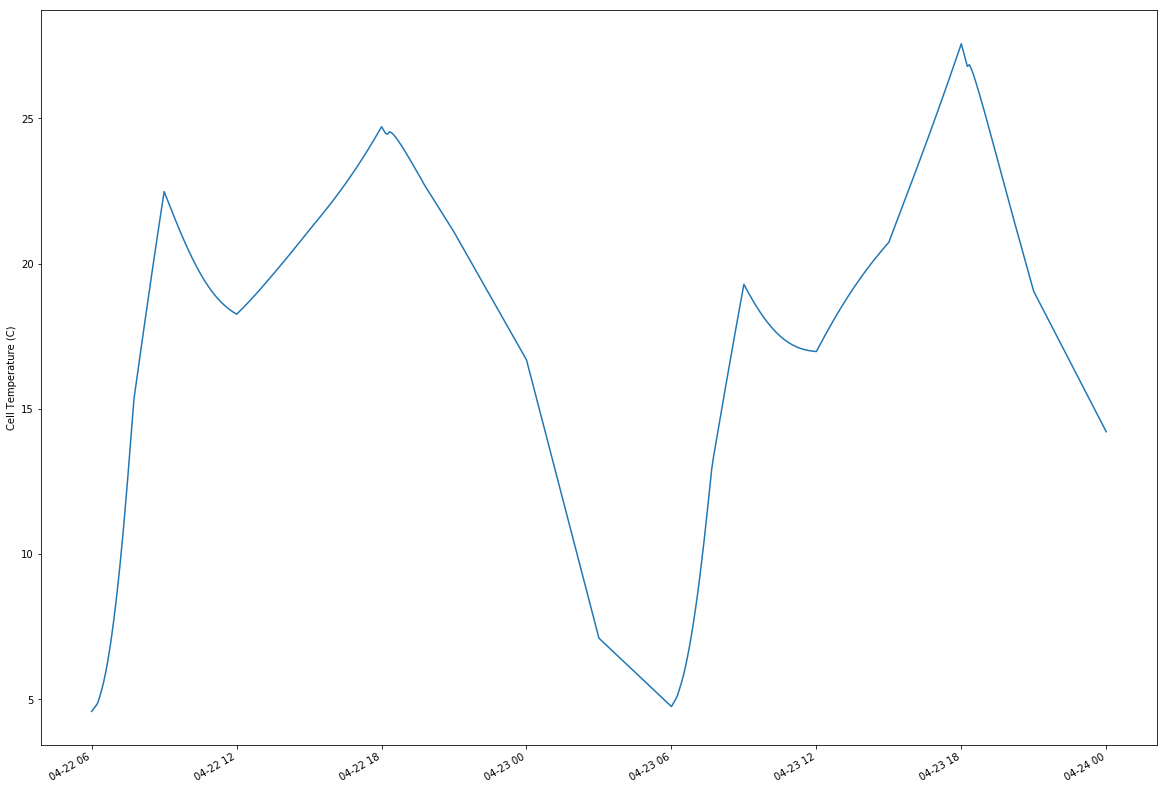

In [65]:
# Cell and module temperature
mc.cell_temperature.plot(figsize=(20,15));
plt.ylabel('Cell Temperature (C)');

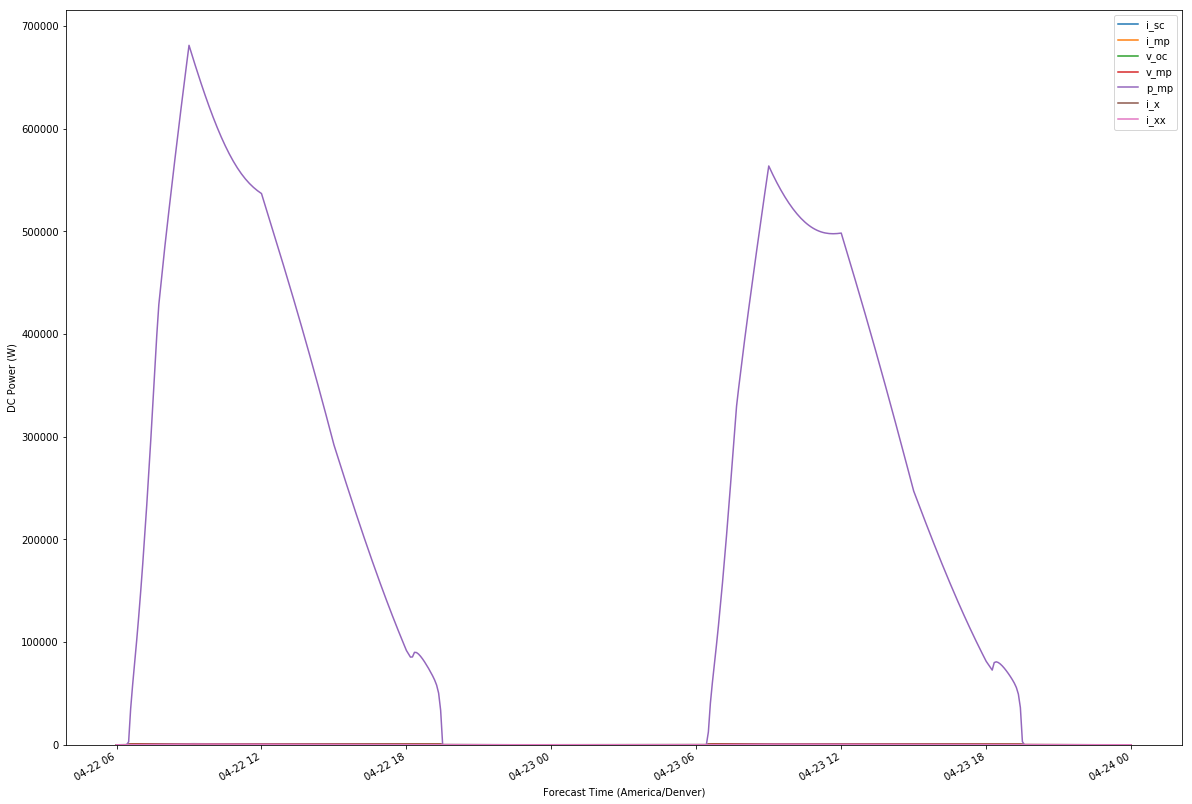

In [66]:
mc.dc.fillna(0).plot(figsize=(20,15));
plt.ylim(0, None);
plt.ylabel('DC Power (W)');
plt.xlabel('Forecast Time ({})'.format(tz));

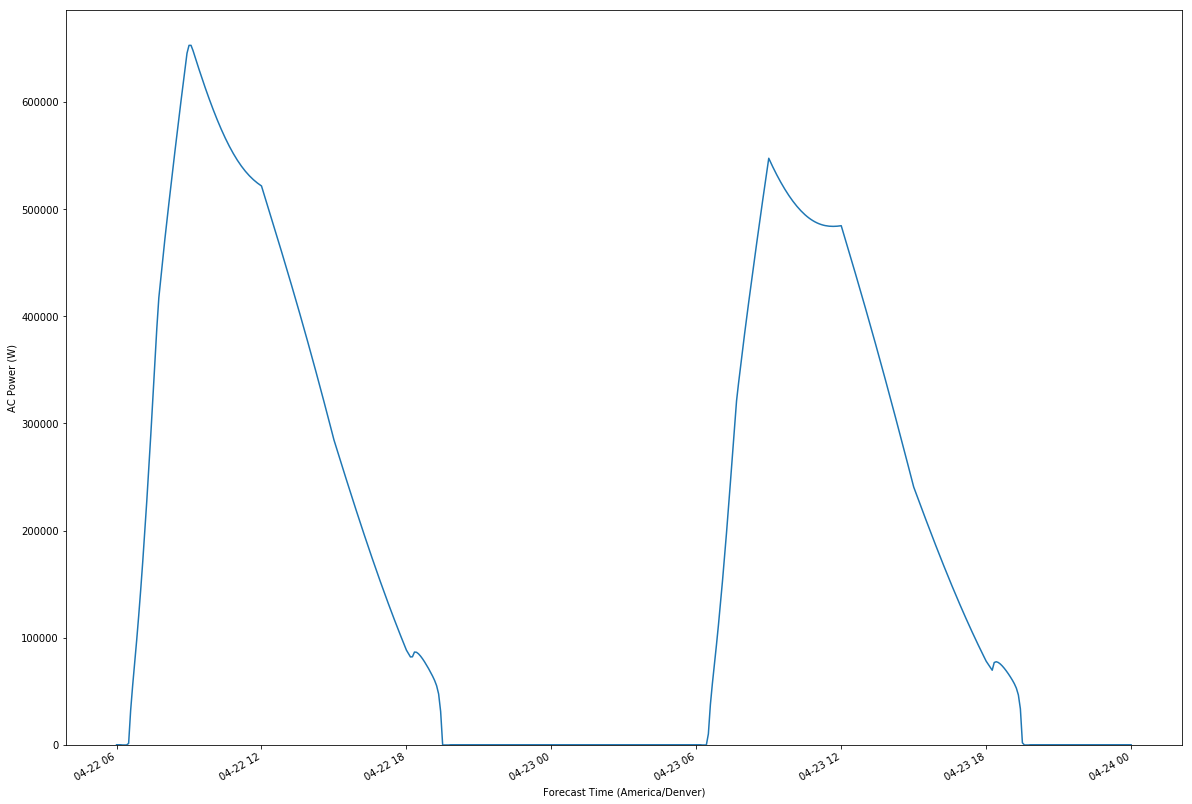

In [67]:
# AC Power
mc.ac.fillna(0).plot(figsize=(20,15));
plt.ylim(0, None);
plt.ylabel('AC Power (W)');
plt.xlabel('Forecast Time ({})'.format(tz));

In [68]:
mc.ac.fillna(0)

2020-04-22 06:00:00-06:00         0.000000
2020-04-22 06:05:00-06:00         0.000000
2020-04-22 06:10:00-06:00         0.000000
2020-04-22 06:15:00-06:00      -195.900000
2020-04-22 06:20:00-06:00      -195.900000
2020-04-22 06:25:00-06:00      -195.900000
2020-04-22 06:30:00-06:00      1288.231461
2020-04-22 06:35:00-06:00     32069.306258
2020-04-22 06:40:00-06:00     55324.876902
2020-04-22 06:45:00-06:00     76282.490926
2020-04-22 06:50:00-06:00     97665.469645
2020-04-22 06:55:00-06:00    120409.005999
2020-04-22 07:00:00-06:00    144752.268632
2020-04-22 07:05:00-06:00    170687.258938
2020-04-22 07:10:00-06:00    198142.673312
2020-04-22 07:15:00-06:00    227054.614880
2020-04-22 07:20:00-06:00    257378.909687
2020-04-22 07:25:00-06:00    289059.826867
2020-04-22 07:30:00-06:00    321944.225816
2020-04-22 07:35:00-06:00    355588.897142
2020-04-22 07:40:00-06:00    388772.586991
2020-04-22 07:45:00-06:00    417283.480962
2020-04-22 07:50:00-06:00    435661.822033
2020-04-22 

In [69]:
mc.ac.describe()

count       326.000000
mean     311380.564192
std      191439.807993
min        -195.900000
25%      127781.206049
50%      320030.999464
75%      487016.819523
max      653000.000000
dtype: float64

In [70]:
mc.ac.fillna(0).to_csv('5 min AC.csv', encoding='utf-8')

# NREL Data
## Wednesday & Thursday
### Irradiance & Temperature

In [6]:
# Read Irradiance & Temperature data
nrel_df = pd.read_csv('Apr 22 23 Entire Day.txt')
print("Keys of nrel_df: \n{}".format(nrel_df.keys()))

Keys of nrel_df: 
Index(['DATE (MM/DD/YYYY)', 'MST', 'Global Horizontal [W/m^2]',
       'Direct Normal [W/m^2]', 'Diffuse Horizontal [W/m^2]'],
      dtype='object')


In [7]:
# Columns Rename - Remove [ ]
nrel_df = nrel_df.rename(columns = {'Global Horizontal [W/m^2]': 'GHI', 'Direct Normal [W/m^2]': 'DNI', 'DATE (MM/DD/YYYY)': 'DATE', 'Diffuse Horizontal [W/m^2]': 'DHI'})

In [8]:
# Analyzing Data
# Global Horizonal & Direct Normal(W/m*2)
# Air Temperature (deg C)
nrel_df.describe()

,GHI,DNI,DHI
count,2880.000000,2880.000000,2880.000000
mean,206.484150,151.365566,118.564186
std,275.643056,268.741618,144.193475
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,63.799850,0.000000,48.581600
75%,338.264000,183.944500,220.825750
max,1212.100000,915.162000,561.403000


In [9]:
# Columns that contain NaN values (True = Nan value)
nrel_df.isnull().any()

DATE    False
MST     False
GHI     False
DNI     False
DHI     False
dtype: bool

In [10]:
nrel_df['Time'] = pd.to_datetime(nrel_df['MST'])

In [11]:
nrel_df['Time'].dt.hour + nrel_df['Time'].dt.minute/60

0        0.000000
1        0.016667
2        0.033333
3        0.050000
4        0.066667
5        0.083333
6        0.100000
7        0.116667
8        0.133333
9        0.150000
10       0.166667
11       0.183333
12       0.200000
13       0.216667
14       0.233333
15       0.250000
16       0.266667
17       0.283333
18       0.300000
19       0.316667
20       0.333333
21       0.350000
22       0.366667
23       0.383333
24       0.400000
25       0.416667
26       0.433333
27       0.450000
28       0.466667
29       0.483333
          ...    
2850    23.500000
2851    23.516667
2852    23.533333
2853    23.550000
2854    23.566667
2855    23.583333
2856    23.600000
2857    23.616667
2858    23.633333
2859    23.650000
2860    23.666667
2861    23.683333
2862    23.700000
2863    23.716667
2864    23.733333
2865    23.750000
2866    23.766667
2867    23.783333
2868    23.800000
2869    23.816667
2870    23.833333
2871    23.850000
2872    23.866667
2873    23.883333
2874    23

In [12]:
nrel_df['Time Float'] = nrel_df['Time'].dt.hour + nrel_df['Time'].dt.minute/60

In [13]:
nrel_df.rename(columns={'Time Float':'Hours', 'MST':'Time', 'Time':'MST'}, inplace=True)

In [14]:
nrel_df.head(10)

,DATE,Time,GHI,DNI,DHI,MST,Hours
0,4/22/2020,00:00,0.000000,0.0,0.000000,2020-05-01 00:00:00,0.000000
1,4/22/2020,00:01,0.037041,0.0,0.037041,2020-05-01 00:01:00,0.016667
2,4/22/2020,00:02,0.000000,0.0,0.000000,2020-05-01 00:02:00,0.033333
3,4/22/2020,00:03,0.037041,0.0,0.037041,2020-05-01 00:03:00,0.050000
4,4/22/2020,00:04,0.037041,0.0,0.037041,2020-05-01 00:04:00,0.066667
5,4/22/2020,00:05,0.000000,0.0,0.000000,2020-05-01 00:05:00,0.083333
6,4/22/2020,00:06,0.000000,0.0,0.000000,2020-05-01 00:06:00,0.100000
7,4/22/2020,00:07,0.000000,0.0,0.000000,2020-05-01 00:07:00,0.116667
8,4/22/2020,00:08,0.000000,0.0,0.000000,2020-05-01 00:08:00,0.133333
9,4/22/2020,00:09,0.000000,0.0,0.000000,2020-05-01 00:09:00,0.150000


In [15]:
nrel_df.tail(10)

,DATE,Time,GHI,DNI,DHI,MST,Hours
2870,4/23/2020,23:50,0.0,0.0,0.0,2020-05-01 23:50:00,23.833333
2871,4/23/2020,23:51,0.0,0.0,0.0,2020-05-01 23:51:00,23.850000
2872,4/23/2020,23:52,0.0,0.0,0.0,2020-05-01 23:52:00,23.866667
2873,4/23/2020,23:53,0.0,0.0,0.0,2020-05-01 23:53:00,23.883333
2874,4/23/2020,23:54,0.0,0.0,0.0,2020-05-01 23:54:00,23.900000
2875,4/23/2020,23:55,0.0,0.0,0.0,2020-05-01 23:55:00,23.916667
2876,4/23/2020,23:56,0.0,0.0,0.0,2020-05-01 23:56:00,23.933333
2877,4/23/2020,23:57,0.0,0.0,0.0,2020-05-01 23:57:00,23.950000
2878,4/23/2020,23:58,0.0,0.0,0.0,2020-05-01 23:58:00,23.966667
2879,4/23/2020,23:59,0.0,0.0,0.0,2020-05-01 23:59:00,23.983333


In [17]:
nrel_df = nrel_df[["DATE","MST","Time","Hours","GHI","DHI","DNI"]]

In [18]:
nrel_df.head()

,DATE,MST,Time,Hours,GHI,DHI,DNI
0,4/22/2020,2020-05-01 00:00:00,00:00,0.000000,0.000000,0.000000,0.0
1,4/22/2020,2020-05-01 00:01:00,00:01,0.016667,0.037041,0.037041,0.0
2,4/22/2020,2020-05-01 00:02:00,00:02,0.033333,0.000000,0.000000,0.0
3,4/22/2020,2020-05-01 00:03:00,00:03,0.050000,0.037041,0.037041,0.0
4,4/22/2020,2020-05-01 00:04:00,00:04,0.066667,0.037041,0.037041,0.0


In [19]:
nrel_df.tail()

,DATE,MST,Time,Hours,GHI,DHI,DNI
2875,4/23/2020,2020-05-01 23:55:00,23:55,23.916667,0.0,0.0,0.0
2876,4/23/2020,2020-05-01 23:56:00,23:56,23.933333,0.0,0.0,0.0
2877,4/23/2020,2020-05-01 23:57:00,23:57,23.950000,0.0,0.0,0.0
2878,4/23/2020,2020-05-01 23:58:00,23:58,23.966667,0.0,0.0,0.0
2879,4/23/2020,2020-05-01 23:59:00,23:59,23.983333,0.0,0.0,0.0


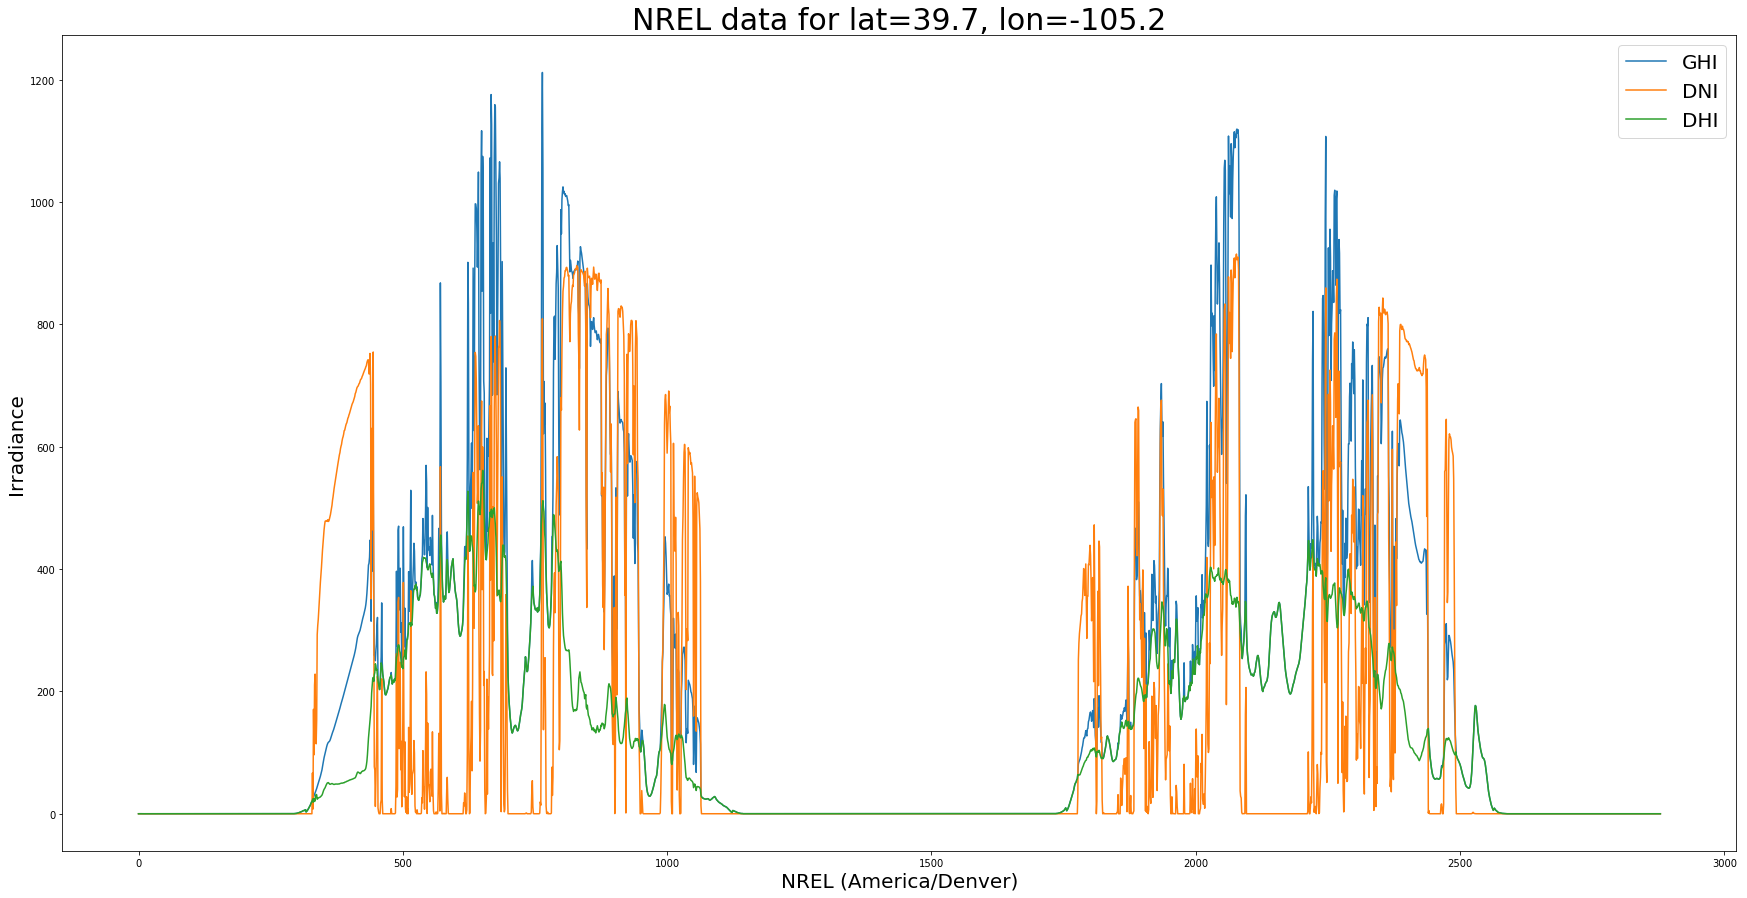

In [20]:
# Plot cloud cover percentages
irrad_var = ['GHI', 'DNI','DHI']
nrel_df[irrad_var].plot(figsize=(30,15));
plt.ylabel('Irradiance',size=20);
plt.xlabel('NREL ({})'.format(tz),size=20);
plt.title('NREL data for lat={}, lon={}'.format(latitude, longitude),size=30);
plt.legend(prop={'size': 20});

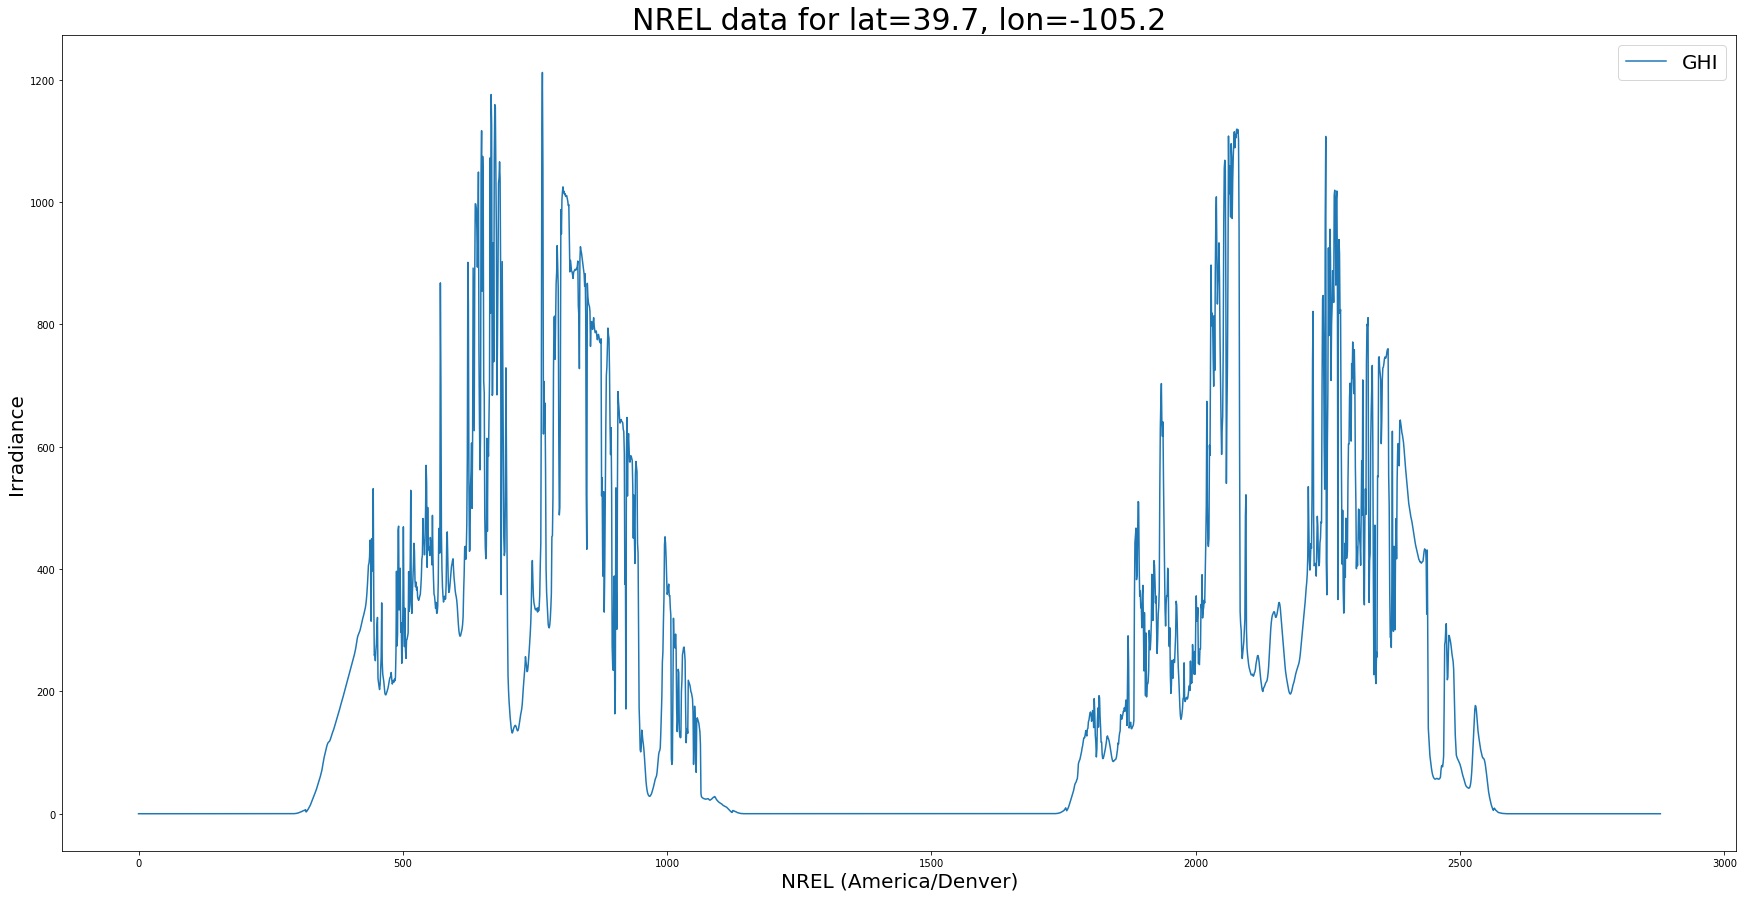

In [21]:
# Plot cloud cover percentages
irrad_var = ['GHI']
nrel_df[irrad_var].plot(figsize=(30,15));
plt.ylabel('Irradiance',size=20);
plt.xlabel('NREL ({})'.format(tz),size=20);
plt.title('NREL data for lat={}, lon={}'.format(latitude, longitude),size=30);
plt.legend(prop={'size': 20});

In [47]:
nrel_df_slice = nrel_df.iloc[::180]

In [48]:
nrel_df_slice

,DATE,MST,Time,Hours,GHI,DHI,DNI
0,4/22/2020,2020-05-01 00:00:00,00:00,0.0,0.000000,0.000000,0.0000
180,4/22/2020,2020-05-01 03:00:00,03:00,3.0,0.000000,0.000000,0.0000
360,4/22/2020,2020-05-01 06:00:00,06:00,6.0,117.504000,50.070400,478.6490
540,4/22/2020,2020-05-01 09:00:00,09:00,9.0,446.740000,417.616000,43.4305
720,4/22/2020,2020-05-01 12:00:00,12:00,12.0,144.644000,144.644000,0.0000
900,4/22/2020,2020-05-01 15:00:00,15:00,15.0,388.788000,163.086000,337.2000
1080,4/22/2020,2020-05-01 18:00:00,18:00,18.0,22.426000,22.426000,0.0000
1260,4/22/2020,2020-05-01 21:00:00,21:00,21.0,0.000000,0.000000,0.0000
1440,4/23/2020,2020-05-01 00:00:00,00:00,0.0,0.000000,0.000000,0.0000
1620,4/23/2020,2020-05-01 03:00:00,03:00,3.0,0.000000,0.000000,0.0000


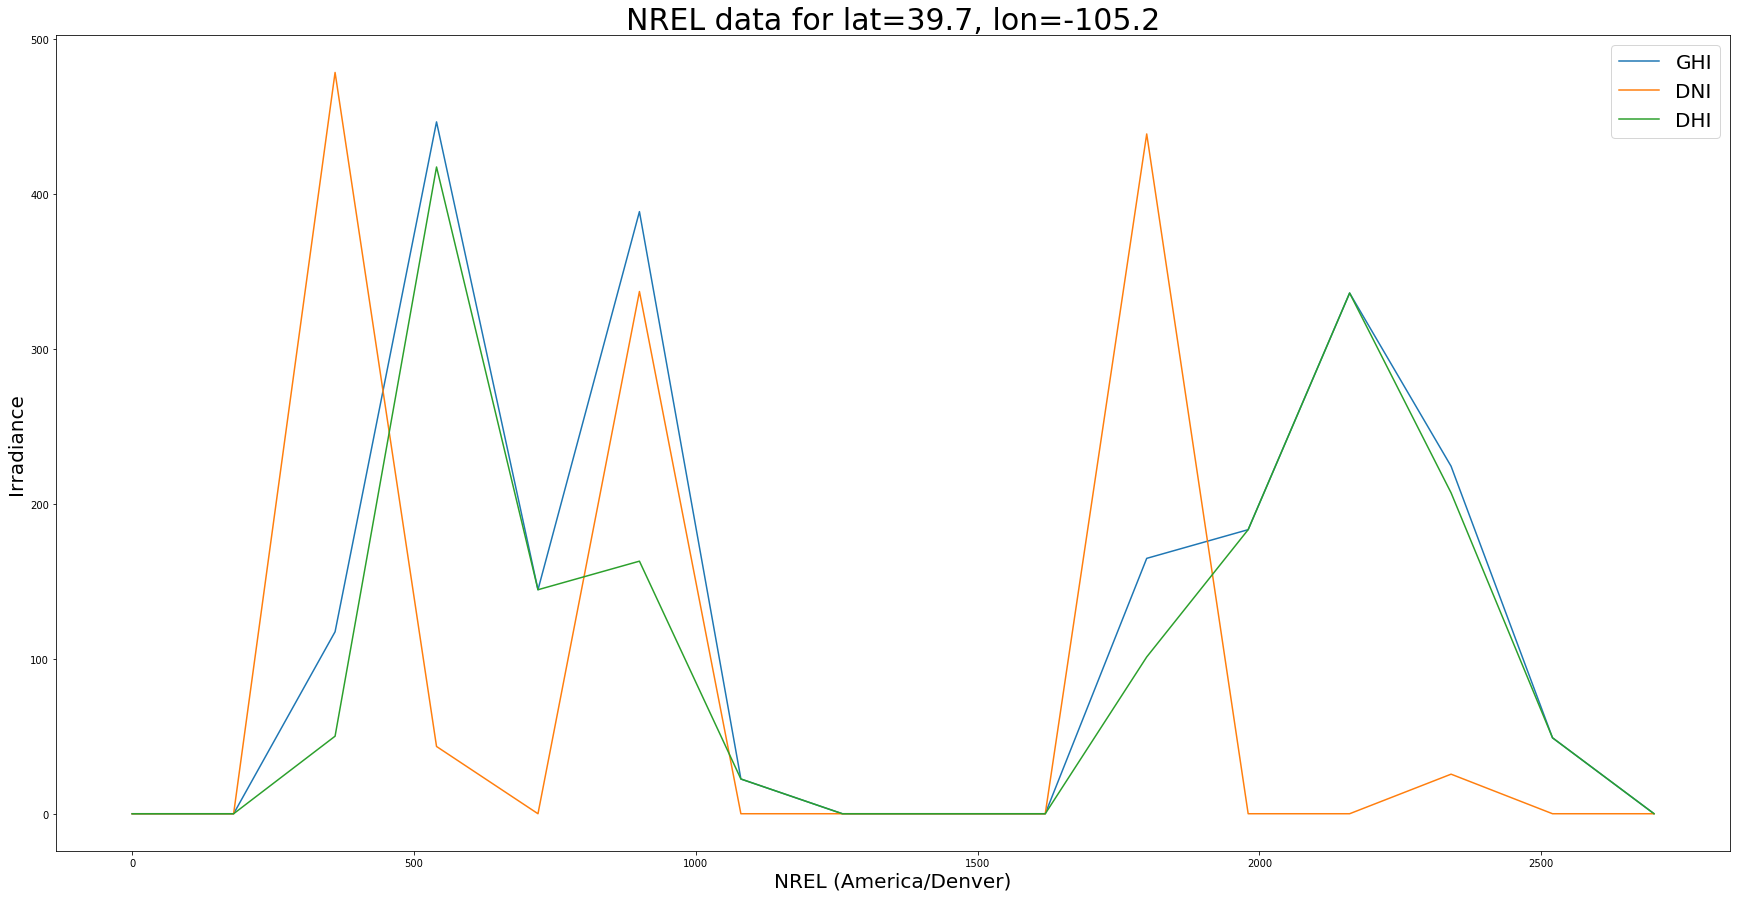

In [49]:
# Plot cloud cover percentages
irrad_var = ['GHI', 'DNI','DHI']
nrel_df_slice[irrad_var].plot(figsize=(30,15));
plt.ylabel('Irradiance', size=20);
plt.xlabel('NREL ({})'.format(tz), size=20);
plt.title('NREL data for lat={}, lon={}'.format(latitude, longitude), size=30);
plt.legend(prop={'size': 20});

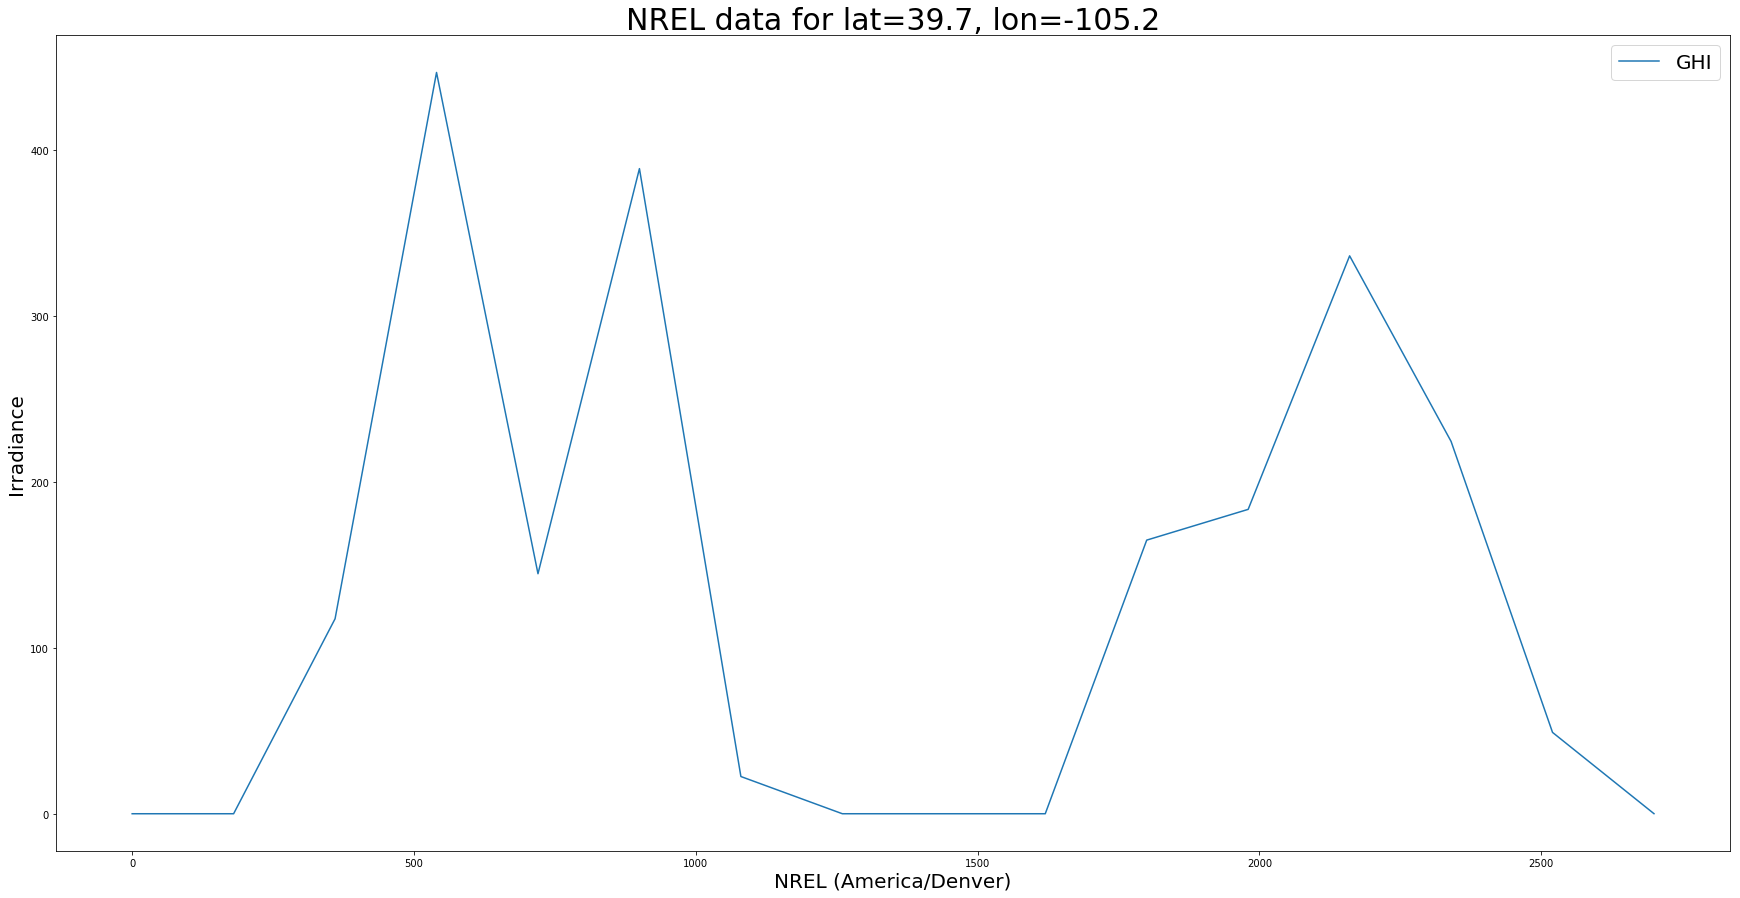

In [50]:
# Plot cloud cover percentages
irrad_var = ['GHI']
nrel_df_slice[irrad_var].plot(figsize=(30,15));
plt.ylabel('Irradiance', size=20);
plt.xlabel('NREL ({})'.format(tz), size=20);
plt.title('NREL data for lat={}, lon={}'.format(latitude, longitude), size=30);
plt.legend(prop={'size': 20});